(gravity-code)=

# Gravity

```{figure} ./images/open_code.png
---
scale: 30%
align: right
---
```

This section demonstrates the processing and inversion of the Forrestania gravity dataset using purely open-source packages. For an equivalent and streamlined version, see the parent [Forrestania](forrestania) case study.

```{note}
The steps taken in this tutorial are strongly based on the official [SimPEG Tutorials](https://simpeg.xyz/user-tutorials/).
```

In [1]:
# Import necessary Python libraries for data handling and visualization
import os
import zipfile
from pathlib import Path
from tempfile import mkdtemp

import discretize
import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy as sp
import simpeg
from geoh5py import Workspace, objects
from PIL import Image

# Import SimPEG library
from simpeg import (
    dask,  # Parallel version of the code
    potential_fields,
)

# Mira Geoscience specific libraries
from simpeg_drivers import assets_path

## Geological setting

See the [Forrestania-Geology](forrestania-geology) section for more background information.

## Data Preparation

This step involves importing and formatting the necessary datasets using various open-source packages.

### Download and unzip the dataset

We first need to unzip the package and import the data into a usable format.

The zipped package contains the following three files:
 - Ground gravity survey: `Forrestania_Gravity_Station_trim_.csv`
 - Digital Elevation Model (DEM): `Forrestania_SRTM1 Australia_MGA50.tiff`

In [2]:
# Create a temporary directory for extracting the zip contents
temp_dir = Path(mkdtemp())

# Use the `assets_path()` from Mira Geoscience's simpeg_drivers to download and locate the Forrestania dataset
# This gives us the full path to the zip file we want to extract
file = assets_path() / r"Case studies/Forrestania_SRTM1 Australia_MGA50_CSV.zip"

# Print the resolved path to confirm where the file is located on disk
print(f"Dataset path: {file}")

# Extract all contents of the zip file into the temporary directory
with zipfile.ZipFile(file, "r") as zf:
    zf.extractall(temp_dir)

# List all the files that were extracted
files = list(temp_dir.iterdir())

Dataset path: C:\Users\dominiquef\Documents\GIT\mira\simpeg-drivers\simpeg_drivers-assets\Case studies\Forrestania_SRTM1 Australia_MGA50_CSV.zip


### Processing Elevation Data

We will use Mira Geoscience's `geoh5py` library to read the geotiff file. 

#### Step 1: Convert the geoImage to a 2D Grid with values

We will utilize the functionality made available in the `geoh5py` library to read and convert the geotiff to a gridded DEM with geographic coordinates.

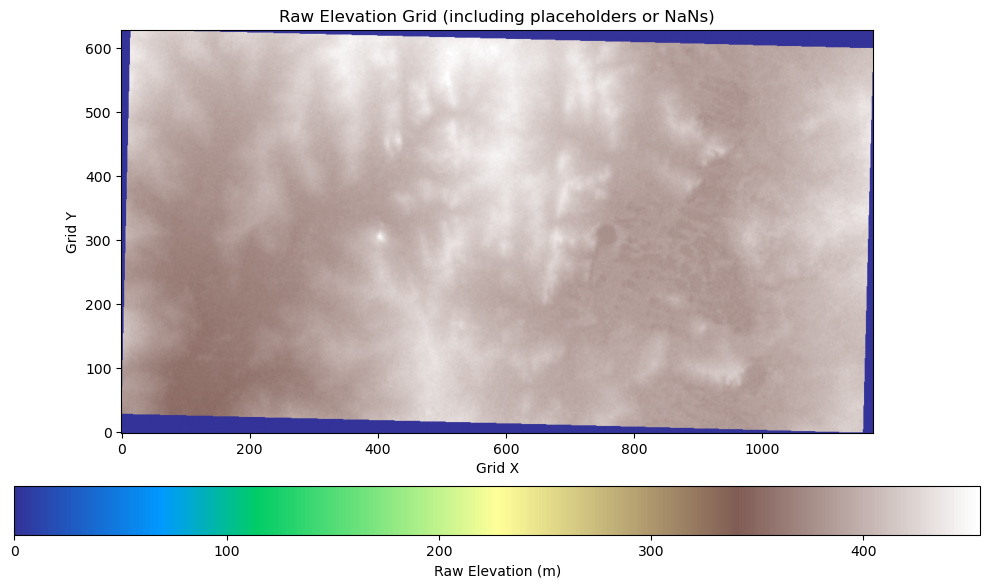

In [3]:
# Load the elevation GeoTIFF using geoh5py
ws = Workspace()
geotiff = objects.GeoImage.create(
    ws, image=str(next(file for file in files if "SRTM1" in file.name))
)

# Register the geospatial reference system from the TIFF metadata using geoh5py
geotiff.georeferencing_from_tiff()

# Convert the image into a grid object (2D array of elevations) in geoh5py
grid = geotiff.to_grid2d()
elevations = grid.children[0].values  # Extract elevation values

# Visualise the raw elevation data (some values may be small placeholders, zeros or NaNs)
fig, ax = plt.subplots(figsize=(10, 6))
elev_image = elevations.reshape(grid.shape, order="F").T
im = ax.imshow(elev_image, cmap="terrain", origin="lower")

cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Raw Elevation (m)")

ax.set_title("Raw Elevation Grid (including placeholders or NaNs)")
ax.set_xlabel("Grid X")
ax.set_ylabel("Grid Y")
plt.tight_layout()
plt.show()

#### Clean Up Invalid Elevation Values
We also need to remove the zeros from the rotated DEM.

In [4]:
# Check minimum elevation value
print(f"Minimum elevation value: {np.nanmin(elevations)}")

Minimum elevation value: 1.1754943508222875e-38


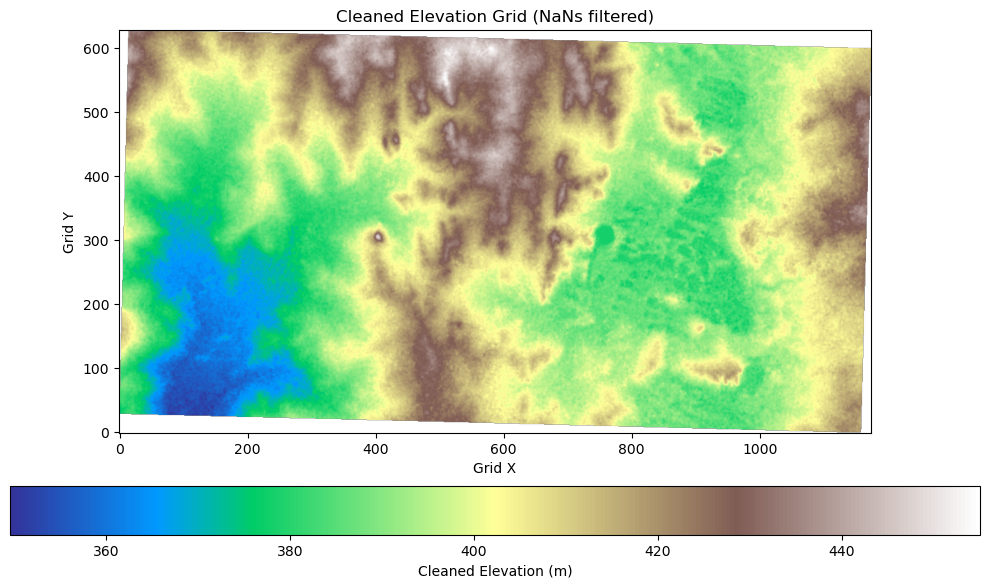

In [5]:
# Some elevation values are tiny placeholders for "no data", replace with NaN
logic = np.abs(elevations) < 2e-38
elevations = np.where(logic, np.nan, elevations)

# Plot cleaned-up elevation map
fig, ax = plt.subplots(figsize=(10, 6))
cleaned_elev_image = elevations.reshape(grid.shape, order="F").T
im = ax.imshow(cleaned_elev_image, cmap="terrain", origin="lower")

cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Cleaned Elevation (m)")

ax.set_title("Cleaned Elevation Grid (NaNs filtered)")
ax.set_xlabel("Grid X")
ax.set_ylabel("Grid Y")
plt.tight_layout()
plt.show()

In [6]:
# Our final DEM DEM array: [X, Y, Elevation]
dem = np.c_[grid.centroids[:, :2], elevations]

## Data

We will use the `pandas` library to read the CSV file. 

In [7]:
# Read the two CSVs with pandas
grav_dataframe = pandas.read_csv(next(file for file in files if "Gravity" in file.name))
grav_dataframe

,X,Y,Z,FGrav_mgal
0,748151.81,6416320.5,380.31,0.147
1,748034.16,6416308.5,380.62,0.233
2,747994.06,6416313.0,380.57,0.284
3,747709.00,6416310.0,380.26,0.519
4,747416.75,6416310.0,375.74,0.359
...,...,...,...,...
987,748056.18,6419203.5,382.12,0.037
988,748379.12,6419225.5,381.77,-0.022
989,748666.29,6419202.5,383.24,-0.015
990,748956.78,6419211.5,382.97,-0.012


### Processing

In this case, the survey is already located at the surface, and the data are already provided as terrain corrected (2.67 g/cc) in mGal. No extra transformation is required. 

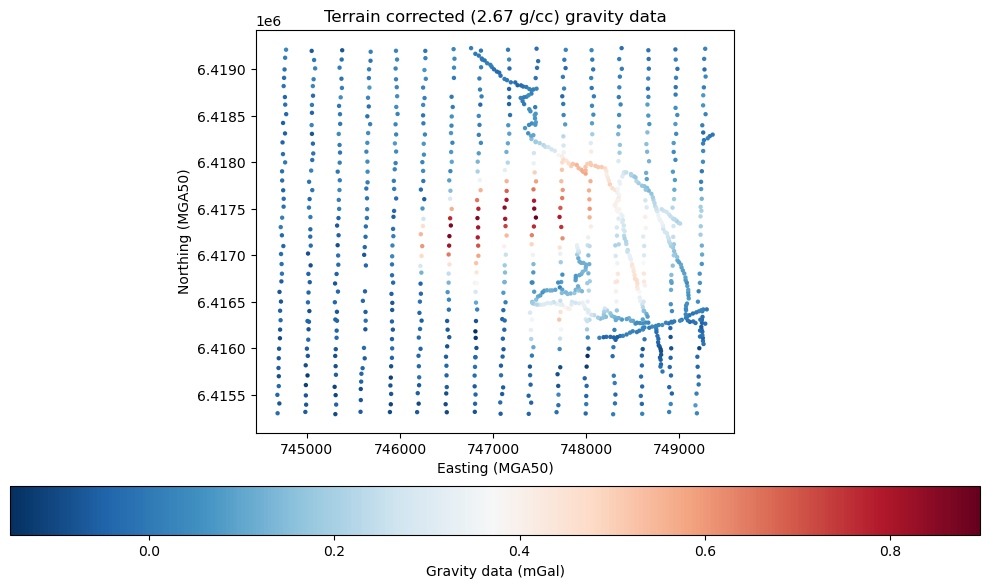

In [26]:
grav_survey = grav_dataframe.to_numpy()

fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(
    grav_survey[:, 0],
    grav_survey[:, 1],  # X and Y coordinates
    c=grav_survey[:, -1],  # Color is based on elevation
    marker="o",  # Circle markers
    cmap="RdBu_r",
    s=10,  # Size of points slightly larger for visibility
    edgecolors="none",
)

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label("Gravity data (mGal)")

ax.set_aspect("equal")
ax.set_title("Terrain corrected (2.67 g/cc) gravity data")
ax.set_xlabel("Easting (MGA50)")
ax.set_ylabel("Northing (MGA50)")
plt.tight_layout()
plt.show()

(forrestania-gravity-inv)=
## Inversion

We proceed with the inversion of the ground gravity data. Our goal is to model the shape and position of geological units in 3D based on density contrasts.

### Create a mesh

We need to break down the subsurface into a grid of cells under the following considerations: use the least number of cells to remain computationally efficient while having enough resolution to model small features accurately. We can achieve both goals with an octree mesh.

In [9]:
# Determine the smallest cell size, half the flight height and data resolution
base_cells = [30, 30, 30]

# Create the base TreeMesh grid (without refinement)
grav_octree = discretize.utils.mesh_builder_xyz(
    grav_survey[:, :3],  # Keep the same extent towards the joint
    base_cells,
    mesh_type="tree",
    depth_core=2000,  # At least as deep as 2000 m
)


# Refine around each receiver location
grav_octree.refine_points(
    grav_survey[:, :3],
    level=-1,  # Use the (last) highest level
    padding_cells_by_level=[6, 6, 6],  # Number of cells at 30 m, 60 m and 120 m
    finalize=False,
)

# Refine along topography
grav_octree.refine_surface(
    dem,
    level=-3,  # Only refine at 120 m on dem
    padding_cells_by_level=[1],
    finalize=True,  # Complete the mesh on our last call
)

### Defining the air-ground domains

We need to tell the inversion what part of the octree grid lies below the surface. 

In [10]:
active = discretize.utils.active_from_xyz(grav_octree, dem)
n_actives = int(active.sum())
print(f"Number of active cells: {n_actives}")

Number of active cells: 227387


### Survey and Simulation

We now define the "geophysical" experiment in terms of survey configurations, and tell SimPEG how to simulate data. 

In [11]:
# Create a survey with receivers
receiver_list = potential_fields.gravity.receivers.Point(
    grav_survey[:, :3], components=["gz"]
)

# Define the inducing field parameter ("the source")
source_field = potential_fields.gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = potential_fields.gravity.survey.Survey(source_field)

# Put it all together
simulation = potential_fields.gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=grav_octree,
    active_cells=active,
    rhoMap=simpeg.maps.IdentityMap(nP=n_actives),
)

### Data and uncertainties

We can create a `SimPEG.Data` that defines the observed data and uncertainties.

In [12]:
# Create a Data class that contains everything
data = simpeg.Data(
    survey,
    dobs=grav_survey[:, -1],
    standard_deviation=0.025,  # Assign the data uncertainty to a quarter of the standard deviation
)

### Data misfit function

One of the main requirements for the inversion is to find a model that replicates the observed data. We enforce that constraint with a least-square measure of data fit.

In [13]:
data_misfit = simpeg.data_misfit.L2DataMisfit(data=data, simulation=simulation)

### Regularization function

In order to constrain the model, we need to add a `regularization` function. We will use a function that can promote sparsity.

In [14]:
regularization = simpeg.regularization.Sparse(
    grav_octree,
    active_cells=active,
    reference_model=np.zeros(n_actives),
    norms=[0, 2, 2, 2],
)

### Inversion directives

We want to control the different steps of the inversions, such as:
 - Initial trade-off parameter
 - Cooling schedule for data fit
 - Sparsity promoting iterations and target

This is done through `Directives`.

In [15]:
sensitivity_weights = simpeg.directives.UpdateSensitivityWeights(every_iteration=False)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=10)
update_jacobi = simpeg.directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = simpeg.directives.UpdateIRLS(max_irls_iterations=25)

directives_list = [
    update_irls,
    sensitivity_weights,
    starting_beta,
    update_jacobi,
]

### Inverse problem

In [16]:
# Define the optimization strategy
optimizer = simpeg.optimization.ProjectedGNCG(maxIter=25)

# Define an inverse problem, the inversion and run
inv_problem = simpeg.inverse_problem.BaseInvProblem(
    data_misfit, regularization, optimizer
)
inversion = simpeg.inversion.BaseInversion(inv_problem, directives_list)

# Create a simple starting model
m_start = np.ones(active.sum()) * 1e-4
rec_model = inversion.run(m_start)


Running inversion with SimPEG v0.22.2.dev43+gcd269b4c1.d20241026
[########################################] | 100% Completed | 8.60 ss
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.24e+02  8.75e+04  2.81e+00  8.79e+04    1.18e+06      0              
   1  6.20e+01  6.57e+04  6.34e+01  6.96e+04    3.58e+05      0              
   2  3.10e+01  5.70e+04  1.65e+02  6.21e+04    2.78e+05      0   Skip BFGS  
   3  1.55e+01  4.78e+04  3.80e+02  5.37e+04    1.94e+05      0   Skip BFGS  
   4  7.75e+00  3.85e+04  8.12e+02  4.48e+04    1.24e+05      0   Skip BFGS  
   5  3.87e+00  2.94e+04  1.66e+03  3.58e+04    7.59e+04      0   Skip BFGS  
   6  1.94e+00  2.11e+04  3.18e+03  2.73e+04    4.38e+04      0   Skip BFGS  
   7  9.68e-01  1.44e+04  5.64e+03  1.99e+04

## Results

### Data fit

Validating the data fit is a critical step before starting any interpratation. Without a good data fit, nothing conclusive can be said about the 3D density model. We want to make sure that most of the signal is captured, leaving only behind random noise (residuals).

Text(0.5, 1.0, 'Residual')

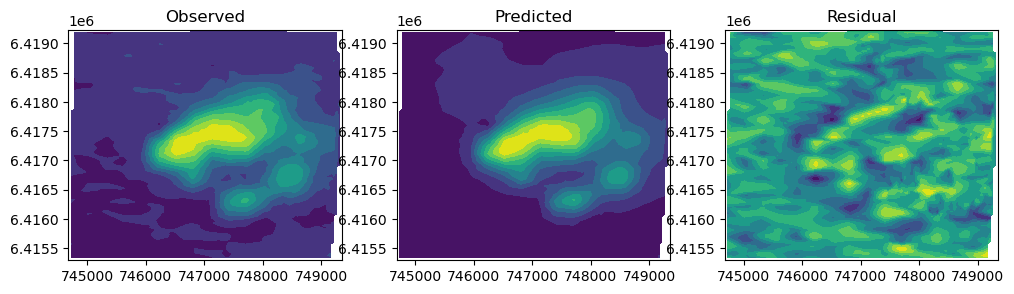

In [17]:
# Validate observed versus predicted
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 3, 1)
simpeg.utils.plot_utils.plot2Ddata(grav_survey[:, :2], grav_survey[:, -1], ax=ax)
ax.set_title("Observed")

ax = plt.subplot(1, 3, 2)
simpeg.utils.plot_utils.plot2Ddata(grav_survey[:, :2], inv_problem.dpred[0], ax=ax)
ax.set_title("Predicted")

ax = plt.subplot(1, 3, 3)
simpeg.utils.plot_utils.plot2Ddata(
    grav_survey[:, :2], grav_survey[:, -1] - inv_problem.dpred[0], ax=ax
)
ax.set_title("Residual")

While there might still be some correlated signal in the residuals, overall the data fit is good. 
We can move on to interpretating the model.

### Models

The inversion took 13 iterations to reach the target misfit, followed by 12 iterations to increase sparsity. The figure below shows horizontal and vertical sections through both solutions. 

See the [Regularization Section](regularization) for more details on sparsity constraints.

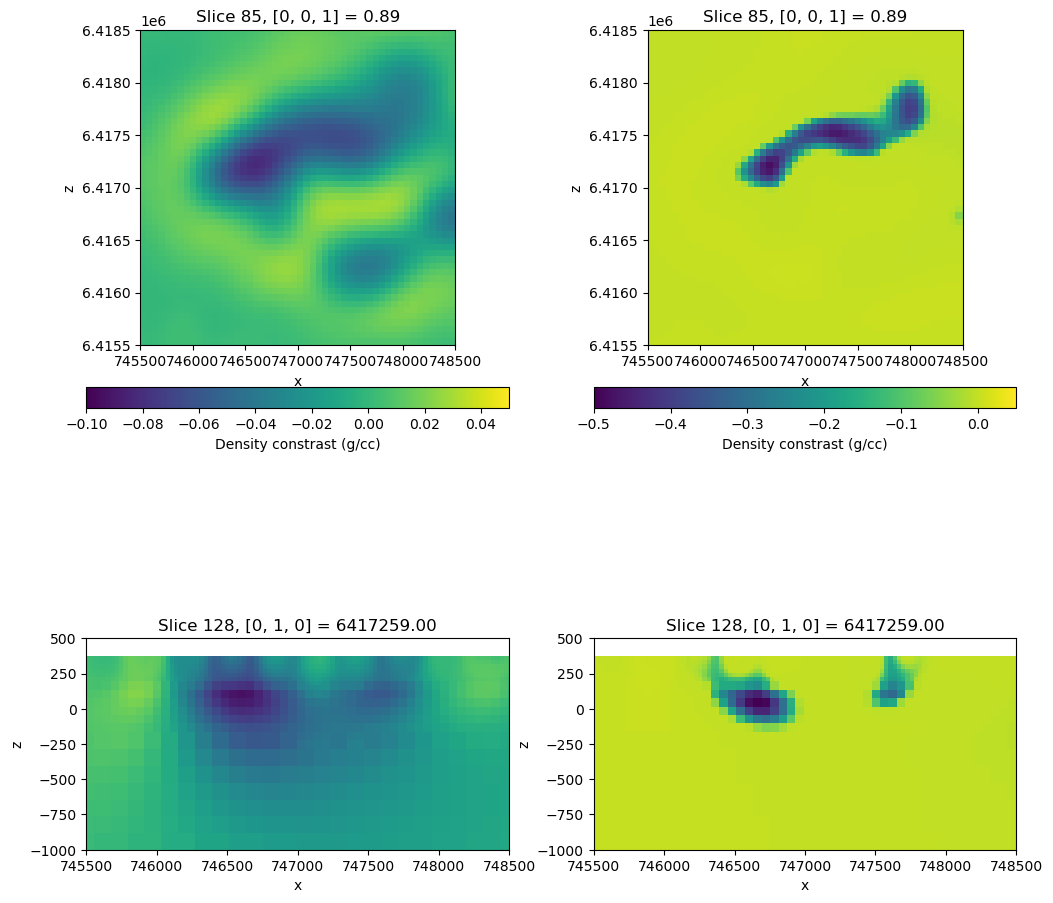

In [25]:
# Mapping to ignore inactive cells when plotting
plotting_map = simpeg.maps.InjectActiveCells(grav_octree, active, np.nan)

fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(2, 2, 1)
im = grav_octree.plot_slice(
    plotting_map * inv_problem.l2model, normal="Z", ind=85, ax=ax, clim=[-0.1, 0.05]
)
ax.set_xlim([745500, 748500])
ax.set_ylim([6415500, 6418500])
ax.set_aspect(1)
cbar = plt.colorbar(im[0], orientation="horizontal", pad=0.1)
cbar.set_label("Density constrast (g/cc)")

ax = plt.subplot(2, 2, 3)
im = grav_octree.plot_slice(
    plotting_map * inv_problem.l2model, normal="Y", ax=ax, clim=[-0.1, 0.05]
)
ax.set_aspect(1)
ax.set_xlim([745500, 748500])
ax.set_ylim([-1000, 500])
ax.set_aspect(1)


ax = plt.subplot(2, 2, 2)
im = grav_octree.plot_slice(
    plotting_map * rec_model, normal="Z", ind=85, ax=ax, clim=[-0.5, 0.05]
)
ax.set_xlim([745500, 748500])
ax.set_ylim([6415500, 6418500])
ax.set_aspect(1)
cbar = plt.colorbar(im[0], orientation="horizontal", pad=0.1)
cbar.set_label("Density constrast (g/cc)")

ax = plt.subplot(2, 2, 4)
im = grav_octree.plot_slice(
    plotting_map * rec_model, normal="Y", ax=ax, clim=[-0.5, 0.05]
)
ax.set_aspect(1)
ax.set_xlim([745500, 748500])
ax.set_ylim([-1000, 500])
ax.set_aspect(1)

We note the following:

 - It took 13 iterations to converge to the target misfit.
 - The following 12 iterations have increased the model complexity ($phi_m$) but preserved the data fit ($phi_d$).
 - Most of the important gravity anomalies appear to be reproduced by the final model.

The smooth solution (iteration 13) indicates the presence of a dense anomaly extending at depth with density contrasts ranging from [-0.1, 0.04] g/cc. The negative density contrasts appear to be localized around the main positive anomaly, likely due to the smoothness constraint and the lack of `bound` constraints. Some smaller "fuzzy" anomalies are visible at the margins.  

As an alternative solution, the compact model (iteration 25) recovers a well-defined dense body within a mostly uniform background. Density contrasts have substantially increased in the range of [-0.5, 0.0] g/cc.
